<a href="https://colab.research.google.com/github/danielahernandz/Series-de-tiempo-avanzado/blob/main/preciosr_retorno_df_acf_ar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts
import seaborn as sns
sns.set()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
raw_csv_data = pd.read_csv('Index2018.csv')
df_comp = raw_csv_data
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

In [ ]:
df_comp['market_value']=df_comp.ftse 

In [ ]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']

In [ ]:
#Datos de entrenamiento y prueba
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

#LLR TEST: 
Contraste de modelos por verosimilitud

DICKEY-FULLER test para ver si presenta o no estacionariedad.
Es un constraste de hipótesis, donde la H0: la serie no es estacionaria/ viene de un proceso no estacionario, H1: la serie si es estacionaria. 

In [ ]:
sts.adfuller(df.market_value)
#-1.92 valor del estadistico d pruebaDF > valor critico según nivel de significación. 
# No se rechaza H0, la serie NO es estacionaria.

#Tambien se puede definir por P-valor del DF (2da linea)
#0.33 >0.05 #No se rechaza H0.

(-1.9041551418836864,
 0.33010893277028336,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

Cuando se la serie no es estacionaria, para que funcione mejor con los modelos AR, se suele tranformar especialmente en Finanzas, para convertir esos precios en datos de retorno. 

Retorno: Es un porcentaje de cambio entre los valores para periodos consecutivos / un % de cambio entre los precios de 2 periodos consecutivos. 
Si el retorno es positivo +, hay un crecimiento en los precios de un día para otro. Y sí es negativo han disminuido.


#Using Returns

In [ ]:
#Tomamos el (periodo act - Pt-1 / Pt-1) * 100 para obtener % de la tasa esto lo realiza pandas con .pct_change
df['returns']= df.market_value.pct_change(1).mul(100) #1 porque es el retraso que deseo: un día
df = df.iloc[1:] #por que posición 0 marca como Nan ya que no existe dia anterior al primer registro.

<ipython-input-8-335f298d4e91>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns']= df.market_value.pct_change(1).mul(100) #1 porque es el retraso que deseo: un día


In [ ]:
df

,market_value,returns
date,,
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166
1994-01-14,3400.56,1.206842
...,...,...
2013-04-01,6411.74,0.000000
2013-04-02,6490.66,1.230867
2013-04-03,6420.28,-1.084327


In [ ]:
sts.adfuller(df.returns)
#P-valor DF: 7.79 * e-24= 10^24= 0.00000000000779  < 0.05 #Rechazamos H0
#-12.77 < valores criticos #Se rechaza con H0, la serie es estacionaria.

(-12.770265719497264,
 7.798058336037375e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.7672456975)

#ACF and PACF for Returns

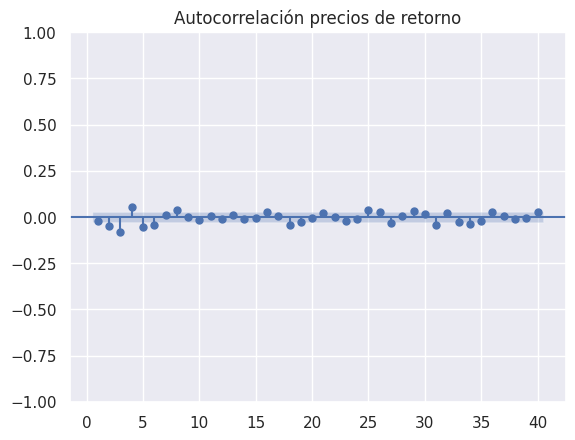

In [ ]:
#Funcion de Autocorrelación captura efectos directos e indirectos 
sgt.plot_acf(df.returns, zero=False, lags=40)
plt.title('Autocorrelación precios de retorno')
plt.show()

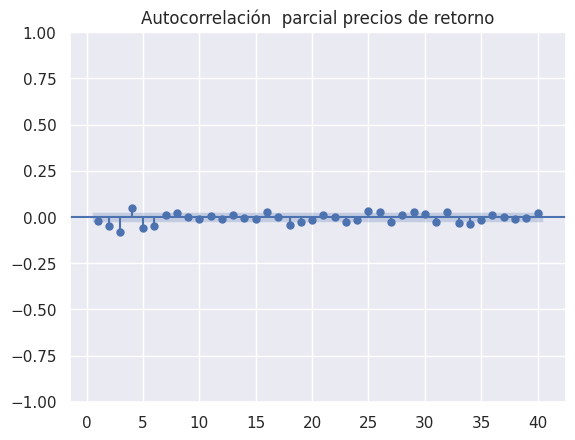

In [ ]:
#Funcion de Autocorrelación parcial captura efectos directos 
sgt.plot_pacf(df.returns, zero=False, lags=40, method= ('ols'))
plt.title('Autocorrelación  parcial precios de retorno')
plt.show(50)

#AR(1) for Returns

In [ ]:
model_ar1 = ARIMA(df.returns, order=(1,0,0))
results_ar1 = model_ar1.fit()
print(results_ar1.summary())

#El coeficiente de rezago de ordén 1 es significativo.

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7929.749
Date:                Tue, 06 Jun 2023   AIC                          15865.497
Time:                        00:28:12   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.143      0.253      -0.013       0.051
ar.L1         -0.0230      0.009     -2.697      0.007      -0.040      -0.006
sigma2         1.3790      0.014    100.092      0.0

#Higher-Lag AR Models for Returns

In [ ]:
model_ar2 = ARIMA(df.returns, order=(2,0,0))
results_ar2 = model_ar2.fit()
print(results_ar2.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7923.456
Date:                Tue, 06 Jun 2023   AIC                          15854.911
Time:                        00:28:20   BIC                          15880.996
Sample:                    01-10-1994   HQIC                         15864.052
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.194      0.233      -0.012       0.050
ar.L1         -0.0242      0.009     -2.799      0.005      -0.041      -0.007
ar.L2         -0.0500      0.008     -6.371      0.0

In [ ]:
model_ar3 = ARIMA(df.returns, order=(3,0,0))
results_ar3 = model_ar1.fit()
print(results_ar3.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7929.749
Date:                Tue, 06 Jun 2023   AIC                          15865.497
Time:                        00:28:22   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.143      0.253      -0.013       0.051
ar.L1         -0.0230      0.009     -2.697      0.007      -0.040      -0.006
sigma2         1.3790      0.014    100.092      0.0

In [ ]:
model_ar4 = ARIMA(df.returns, order=(4,0,0))
results_ar4 = model_ar4.fit()
print(results_ar4.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -7901.330
Date:                Tue, 06 Jun 2023   AIC                          15814.661
Time:                        00:28:25   BIC                          15853.788
Sample:                    01-10-1994   HQIC                         15828.371
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.208      0.227      -0.012       0.049
ar.L1         -0.0245      0.009     -2.770      0.006      -0.042      -0.007
ar.L2         -0.0496      0.008     -6.327      0.0

In [ ]:
model_ar5 = ARIMA(df.returns, order=(5,0,0))
results_ar5 = model_ar5.fit()
print(results_ar5.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -7892.390
Date:                Tue, 06 Jun 2023   AIC                          15798.779
Time:                        00:28:30   BIC                          15844.428
Sample:                    01-10-1994   HQIC                         15814.775
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.273      0.203      -0.010       0.048
ar.L1         -0.0217      0.009     -2.396      0.017      -0.040      -0.004
ar.L2         -0.0544      0.008     -6.826      0.0

In [ ]:
def LLR_test(model_1, model_2, DF=1):
  #hallamos las log-verosimilitudes de los modelos para ello usamos el metodo .llf
  L1 = model_1.llf
  L2 = model_2.llf
  LR = (2*(L2-L1)) #Estadistico
  p = chi2.sf(LR, DF).round(3) #distribución del estadistico es una CHI2, por el estadiscito los grado de libertad y se redondea a  decimales.
  return p

In [ ]:
print(LLR_test(results_ar1, results_ar2)) #significativamente diferentes
print(LLR_test(results_ar2, results_ar3)) #similar
print(LLR_test(results_ar3, results_ar4)) #significativamente diferentes
print(LLR_test(results_ar4, results_ar5)) #significativamente diferentes


0.0
1.0
0.0
0.0


In [ ]:
model_ar6 = ARIMA(df.returns, order=(6,0,0))
results_ar6 = model_ar6.fit()
print(results_ar6.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar5, results_ar6)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -7886.945
Date:                Tue, 06 Jun 2023   AIC                          15789.890
Time:                        00:28:39   BIC                          15842.059
Sample:                    01-10-1994   HQIC                         15808.170
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.324      0.186      -0.009       0.047
ar.L1         -0.0245      0.009     -2.640      0.008      -0.043      -0.006
ar.L2         -0.0523      0.008     -6.505      0.0

In [ ]:
model_ar7 = ARIMA(df.returns, order=(7,0,0))
results_ar7 = model_ar7.fit()
print(results_ar7.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar6, results_ar7)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -7886.647
Date:                Tue, 06 Jun 2023   AIC                          15791.294
Time:                        00:36:05   BIC                          15849.985
Sample:                    01-10-1994   HQIC                         15811.860
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.304      0.192      -0.010       0.047
ar.L1         -0.0240      0.009     -2.579      0.010      -0.042      -0.006
ar.L2         -0.0517      0.008     -6.375      0.0

In [ ]:
print("LLR test:  " + str((LLR_test(results_ar1, results_ar6, DF = 5))))
#Incluir precios de hace 6 días explica mejor los precios de hoy. 
#LLR test:  0.0 rechazamos la H0 de que son similares los modelos, por lo tanto son diferentes y se prefiere el 6

LLR test:  0.0


Residuos

In [ ]:
df['residuos_retorno'] = results_ar1.resid

In [ ]:
sts.adfuller(df.residuos_retorno)
#Se debe cumplir para los residuos, que sea semejantes a ruido blanco, es decir no deben presentar autocorrelación
#y en el test de Dicky Fuller deberiamos obtener que los residuos son significativamente estacionarios.

# Ho(nula): La serie no estacionaria
# H1(alternativa): La serie es estacionaria.

# pvalor DF= 0.0000000000...735 < 0.05 se rechaza H0, por lo tanto los residuos son estacionarios.
# valor estadistico de prueba= -12.78 < A todos los valores criticos, Se rechaza H0, los residuos presentan un comportamiento estacionario.

(-12.782788720769858,
 7.354275022444139e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.449439368527)

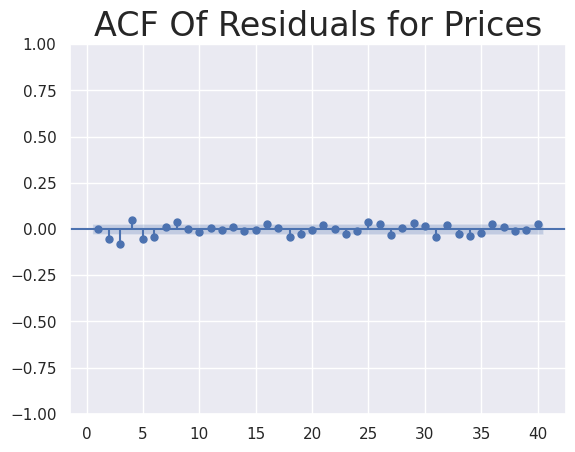

In [ ]:
sgt.plot_acf(df.residuos_retorno, zero = False, lags = 40)
plt.title("ACF Of Residuals for Prices", size=24)
plt.show()
#Autocorrelación los residuos nigun es significativamente distinto de cero son =0 no hay auto.

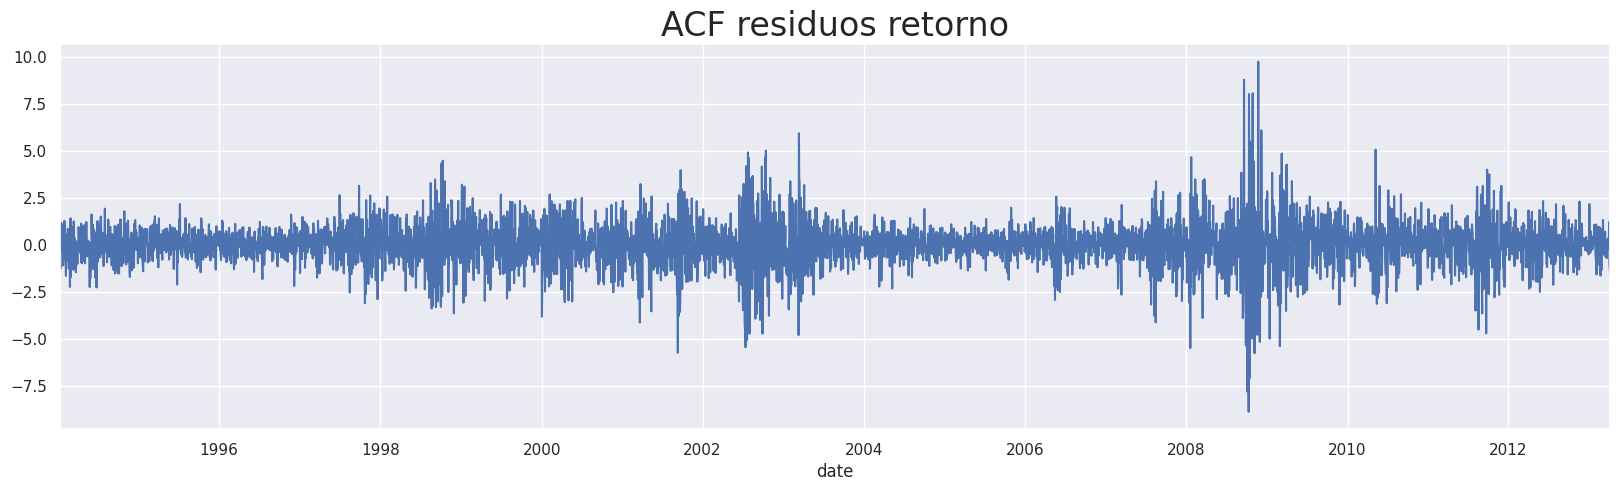

In [ ]:
df.residuos_retorno[1:].plot(figsize=(20,5))
plt.title("ACF residuos retorno", size=24)
plt.show()
